In [1]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [4]:
datasets = {
            'rna': '../data/kipan/RNASeq.csv',
            'cnv': '../data/kipan/CNV.csv',
            'rppa': '../data/kipan/RPPA.csv',
}
        
labels = '../data/kipan/Clinical.csv'

In [13]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (745, 20190)
cnv (745, 24776)
rppa (745, 166)


# Preprocessing

## Removing low-variance + null features

In [7]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    return X_new

In [12]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality])
    print(modality, new_data[modality].shape)

rna (745, 19042)
cnv (745, 5173)
rppa (745, 91)


In [27]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (745, 19042)
cnv (745, 5173)
rppa (745, 75)


In [25]:
subtypes['histological_type'].value_counts()

kidneyclearcellrenalcarcinoma        469
kidneypapillaryrenalcellcarcinoma    213
kidneychromophobe                     63
Name: histological_type, dtype: int64

In [28]:
y = LabelEncoder().fit_transform(subtypes['histological_type'])

# Testing Datasets

In [30]:
def recall_multiclass(y_test, y_pred, label):
    return recall_score(y_test, y_pred, average=None)[label]

In [38]:
from imblearn.pipeline import make_pipeline

In [47]:
'''estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, n_jobs=-1))),
    ("random_forest", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", MLPClassifier(random_state=0)),
    ("svm", make_pipeline(StandardScaler(), SVC(random_state=0)))
]'''

estimators = [
    ("logistic", LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1)),
    ("random_forest", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", MLPClassifier(random_state=0)),
    ("svc", SVC(random_state=0, kernel='linear', max_iter=1000))
]

In [48]:
def get_individual_scores(X, y, estimators, scoring, return_train_score=False):
    base_scores = []
    base_metrics_df = pd.DataFrame()
    base_metrics_df_train = pd.DataFrame()
    
    for name, clf in tqdm(estimators):
        if return_train_score:
            score, df, train_df = get_cross_metrics(clf, X, y, name, scoring=scoring, return_train_score=return_train_score)
            base_metrics_df_train = pd.concat([base_metrics_df_train, train_df])
        else:
            score, df = get_cross_metrics(clf, X, y, name, scoring=scoring, return_train_score=return_train_score)
            
        base_metrics_df = pd.concat([base_metrics_df, df])
        base_scores.append(score)
        
        print(name, df)
    
    if return_train_score:
        return base_scores, base_metrics_df, base_metrics_df_train
    else:
        return base_scores, base_metrics_df
        

In [33]:
pd.Series(y).value_counts()

1    469
2    213
0     63
dtype: int64

In [49]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:25<04:17, 85.76s/it]

logistic                  accuracy               f1    recall (KICH)    recall (KIRC)  \
logistic  0.966 +/- 0.014  0.967 +/- 0.014  0.954 +/- 0.092  0.966 +/- 0.022   

            recall (KIRP)  
logistic  0.972 +/- 0.023  


 50%|█████     | 2/4 [01:39<01:26, 43.23s/it]

random_forest                       accuracy               f1    recall (KICH)  \
random_forest  0.958 +/- 0.021  0.958 +/- 0.021  0.954 +/- 0.092   

                 recall (KIRC)    recall (KIRP)  
random_forest  0.962 +/- 0.020  0.953 +/- 0.033  


 75%|███████▌  | 3/4 [04:31<01:42, 102.35s/it]

deep_nn                 accuracy               f1    recall (KICH)    recall (KIRC)  \
deep_nn  0.764 +/- 0.344  0.744 +/- 0.370  0.800 +/- 0.400  0.753 +/- 0.377   

           recall (KIRP)  
deep_nn  0.781 +/- 0.391  


100%|██████████| 4/4 [04:42<00:00, 70.56s/it] 


svc             accuracy               f1    recall (KICH)    recall (KIRC)  \
svc  0.965 +/- 0.014  0.965 +/- 0.014  0.954 +/- 0.092  0.964 +/- 0.020   

       recall (KIRP)  
svc  0.972 +/- 0.023  


 25%|██▌       | 1/4 [00:13<00:39, 13.14s/it]

logistic                  accuracy               f1    recall (KICH)    recall (KIRC)  \
logistic  0.898 +/- 0.026  0.897 +/- 0.027  0.795 +/- 0.149  0.940 +/- 0.025   

            recall (KIRP)  
logistic  0.836 +/- 0.052  


 50%|█████     | 2/4 [00:17<00:16,  8.26s/it]

random_forest                       accuracy               f1    recall (KICH)  \
random_forest  0.886 +/- 0.024  0.885 +/- 0.023  0.732 +/- 0.159   

                 recall (KIRC)    recall (KIRP)  
random_forest  0.923 +/- 0.032  0.850 +/- 0.052  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 75%|███████▌  | 3/4 [01:18<00:32, 32.09s/it]

deep_nn                 accuracy               f1    recall (KICH)    recall (KIRC)  \
deep_nn  0.870 +/- 0.034  0.869 +/- 0.034  0.717 +/- 0.087  0.906 +/- 0.039   

           recall (KIRP)  
deep_nn  0.836 +/- 0.064  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy               f1    recall (KICH)    recall (KIRC)  \
svc  0.772 +/- 0.063  0.776 +/- 0.062  0.650 +/- 0.167  0.800 +/- 0.050   

       recall (KIRP)  
svc  0.748 +/- 0.130  


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

logistic                  accuracy               f1    recall (KICH)    recall (KIRC)  \
logistic  0.749 +/- 0.009  0.730 +/- 0.013  0.173 +/- 0.093  0.900 +/- 0.017   

            recall (KIRP)  
logistic  0.587 +/- 0.024  


 50%|█████     | 2/4 [00:01<00:01,  1.05it/s]

random_forest                       accuracy               f1    recall (KICH)  \
random_forest  0.881 +/- 0.017  0.862 +/- 0.022  0.241 +/- 0.106   

                 recall (KIRC)    recall (KIRP)  
random_forest  0.994 +/- 0.009  0.821 +/- 0.032  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

deep_nn                 accuracy               f1    recall (KICH)    recall (KIRC)  \
deep_nn  0.914 +/- 0.024  0.911 +/- 0.026  0.685 +/- 0.092  0.977 +/- 0.008   

           recall (KIRP)  
deep_nn  0.845 +/- 0.047  
svc             accuracy               f1    recall (KICH)    recall (KIRC)  \
svc  0.733 +/- 0.034  0.732 +/- 0.030  0.351 +/- 0.128  0.851 +/- 0.048   

       recall (KIRP)  
svc  0.587 +/- 0.046  


In [51]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.014,0.967 +/- 0.014,0.954 +/- 0.092,0.966 +/- 0.022,0.972 +/- 0.023
random_forest,0.958 +/- 0.021,0.958 +/- 0.021,0.954 +/- 0.092,0.962 +/- 0.020,0.953 +/- 0.033
deep_nn,0.764 +/- 0.344,0.744 +/- 0.370,0.800 +/- 0.400,0.753 +/- 0.377,0.781 +/- 0.391
svc,0.965 +/- 0.014,0.965 +/- 0.014,0.954 +/- 0.092,0.964 +/- 0.020,0.972 +/- 0.023


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.898 +/- 0.026,0.897 +/- 0.027,0.795 +/- 0.149,0.940 +/- 0.025,0.836 +/- 0.052
random_forest,0.886 +/- 0.024,0.885 +/- 0.023,0.732 +/- 0.159,0.923 +/- 0.032,0.850 +/- 0.052
deep_nn,0.870 +/- 0.034,0.869 +/- 0.034,0.717 +/- 0.087,0.906 +/- 0.039,0.836 +/- 0.064
svc,0.772 +/- 0.063,0.776 +/- 0.062,0.650 +/- 0.167,0.800 +/- 0.050,0.748 +/- 0.130


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.749 +/- 0.009,0.730 +/- 0.013,0.173 +/- 0.093,0.900 +/- 0.017,0.587 +/- 0.024
random_forest,0.881 +/- 0.017,0.862 +/- 0.022,0.241 +/- 0.106,0.994 +/- 0.009,0.821 +/- 0.032
deep_nn,0.914 +/- 0.024,0.911 +/- 0.026,0.685 +/- 0.092,0.977 +/- 0.008,0.845 +/- 0.047
svc,0.733 +/- 0.034,0.732 +/- 0.030,0.351 +/- 0.128,0.851 +/- 0.048,0.587 +/- 0.046


(None, None, None)

In [52]:
estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("random_forest", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", MLPClassifier(random_state=0)),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

In [53]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

 25%|██▌       | 1/4 [01:01<03:03, 61.13s/it]

logistic                  accuracy               f1    recall (KICH)    recall (KIRC)  \
logistic  0.966 +/- 0.016  0.967 +/- 0.016  0.954 +/- 0.092  0.964 +/- 0.022   

            recall (KIRP)  
logistic  0.977 +/- 0.015  


 50%|█████     | 2/4 [01:10<01:00, 30.49s/it]

random_forest                       accuracy               f1    recall (KICH)  \
random_forest  0.958 +/- 0.021  0.958 +/- 0.021  0.954 +/- 0.092   

                 recall (KIRC)    recall (KIRP)  
random_forest  0.962 +/- 0.020  0.953 +/- 0.033  


 75%|███████▌  | 3/4 [04:05<01:36, 96.63s/it]

deep_nn                 accuracy               f1    recall (KICH)    recall (KIRC)  \
deep_nn  0.764 +/- 0.344  0.744 +/- 0.370  0.800 +/- 0.400  0.753 +/- 0.377   

           recall (KIRP)  
deep_nn  0.781 +/- 0.391  


100%|██████████| 4/4 [04:15<00:00, 63.98s/it]


svc             accuracy               f1    recall (KICH)    recall (KIRC)  \
svc  0.968 +/- 0.018  0.968 +/- 0.018  0.954 +/- 0.092  0.966 +/- 0.025   

       recall (KIRP)  
svc  0.977 +/- 0.015  


  0%|          | 0/4 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|██▌       | 1/4 [00:46<02:20, 46.79s/it]

logistic                  accuracy               f1    recall (KICH)    recall (KIRC)  \
logistic  0.863 +/- 0.021  0.861 +/- 0.022  0.669 +/- 0.118  0.919 +/- 0.026   

            recall (KIRP)  
logistic  0.799 +/- 0.078  


 50%|█████     | 2/4 [00:51<00:44, 22.08s/it]

random_forest                       accuracy               f1    recall (KICH)  \
random_forest  0.886 +/- 0.024  0.885 +/- 0.023  0.732 +/- 0.159   

                 recall (KIRC)    recall (KIRP)  
random_forest  0.923 +/- 0.032  0.850 +/- 0.052  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 75%|███████▌  | 3/4 [01:52<00:40, 40.02s/it]

deep_nn                 accuracy               f1    recall (KICH)    recall (KIRC)  \
deep_nn  0.870 +/- 0.034  0.869 +/- 0.034  0.717 +/- 0.087  0.906 +/- 0.039   

           recall (KIRP)  
deep_nn  0.836 +/- 0.064  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy               f1    recall (KICH)    recall (KIRC)  \
svc  0.796 +/- 0.048  0.798 +/- 0.046  0.655 +/- 0.128  0.840 +/- 0.069   

       recall (KIRP)  
svc  0.742 +/- 0.031  


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

logistic                  accuracy               f1    recall (KICH)    recall (KIRC)  \
logistic  0.742 +/- 0.005  0.731 +/- 0.010  0.223 +/- 0.036  0.874 +/- 0.018   

            recall (KIRP)  
logistic  0.605 +/- 0.041  


 50%|█████     | 2/4 [00:01<00:01,  1.11it/s]

random_forest                       accuracy               f1    recall (KICH)  \
random_forest  0.881 +/- 0.017  0.862 +/- 0.022  0.241 +/- 0.106   

                 recall (KIRC)    recall (KIRP)  
random_forest  0.994 +/- 0.009  0.821 +/- 0.032  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

deep_nn                 accuracy               f1    recall (KICH)    recall (KIRC)  \
deep_nn  0.914 +/- 0.024  0.911 +/- 0.026  0.685 +/- 0.092  0.977 +/- 0.008   

           recall (KIRP)  
deep_nn  0.845 +/- 0.047  
svc             accuracy               f1    recall (KICH)    recall (KIRC)  \
svc  0.631 +/- 0.047  0.646 +/- 0.044  0.492 +/- 0.114  0.682 +/- 0.058   

       recall (KIRP)  
svc  0.559 +/- 0.060  


In [54]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
random_forest,0.958 +/- 0.021,0.958 +/- 0.021,0.954 +/- 0.092,0.962 +/- 0.020,0.953 +/- 0.033
deep_nn,0.764 +/- 0.344,0.744 +/- 0.370,0.800 +/- 0.400,0.753 +/- 0.377,0.781 +/- 0.391
svc,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.966 +/- 0.025,0.977 +/- 0.015


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.021,0.861 +/- 0.022,0.669 +/- 0.118,0.919 +/- 0.026,0.799 +/- 0.078
random_forest,0.886 +/- 0.024,0.885 +/- 0.023,0.732 +/- 0.159,0.923 +/- 0.032,0.850 +/- 0.052
deep_nn,0.870 +/- 0.034,0.869 +/- 0.034,0.717 +/- 0.087,0.906 +/- 0.039,0.836 +/- 0.064
svc,0.796 +/- 0.048,0.798 +/- 0.046,0.655 +/- 0.128,0.840 +/- 0.069,0.742 +/- 0.031


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.742 +/- 0.005,0.731 +/- 0.010,0.223 +/- 0.036,0.874 +/- 0.018,0.605 +/- 0.041
random_forest,0.881 +/- 0.017,0.862 +/- 0.022,0.241 +/- 0.106,0.994 +/- 0.009,0.821 +/- 0.032
deep_nn,0.914 +/- 0.024,0.911 +/- 0.026,0.685 +/- 0.092,0.977 +/- 0.008,0.845 +/- 0.047
svc,0.631 +/- 0.047,0.646 +/- 0.044,0.492 +/- 0.114,0.682 +/- 0.058,0.559 +/- 0.060


(None, None, None)

In [77]:
def plot_scores(estimator_names, scorers, metrics=["f1", "accuracy"]):
    score_lists = {}
    for metric in metrics:
        score_lists[metric] = [score["test_" + metric] for score in scorers]

    for i, (title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        sns.boxplot(data=_list, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, showfliers=False).set_xticklabels(estimator_names, rotation=45)
        plt.title(title)

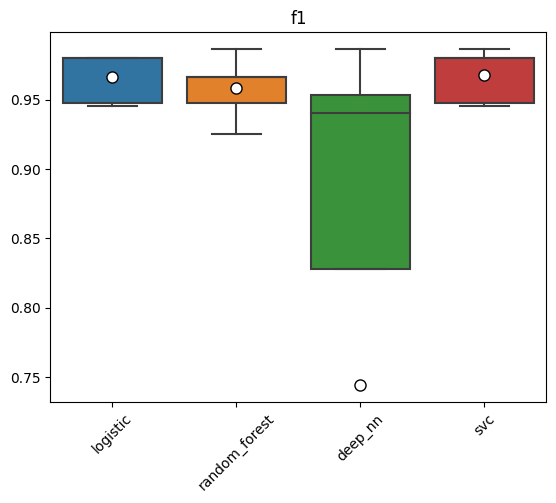

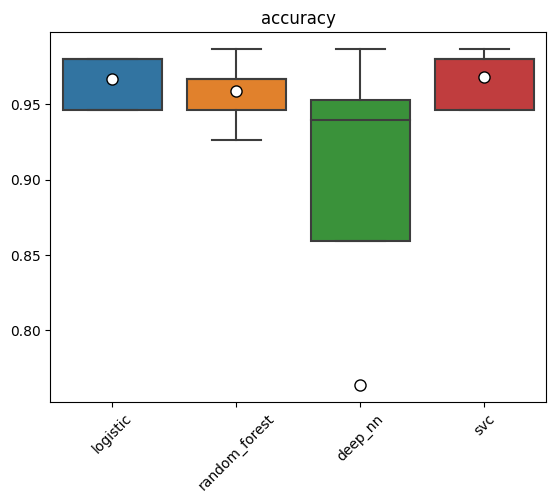

In [78]:
estimator_names = [
    "logistic",
    "random_forest",
    "deep_nn",
    "svc"
]
plot_scores(estimator_names, base_scores['rna'])

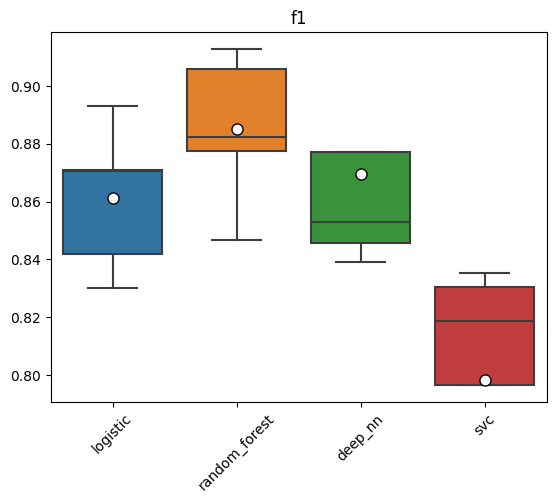

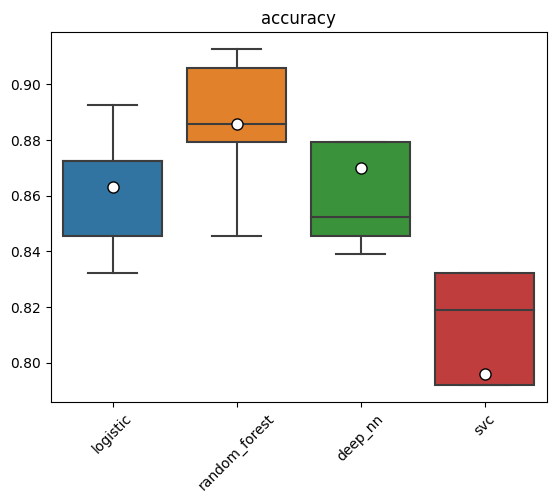

In [79]:
plot_scores(estimator_names, base_scores['cnv'])

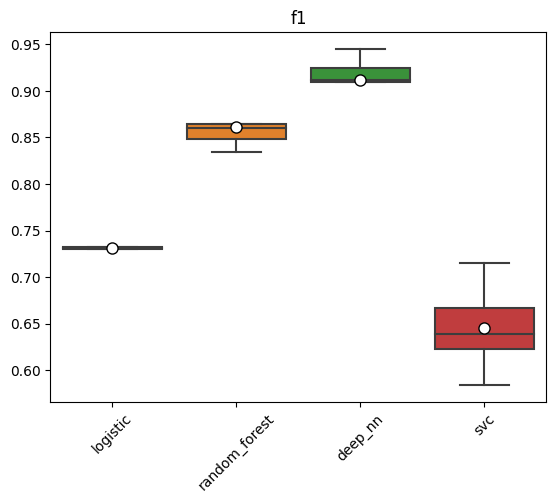

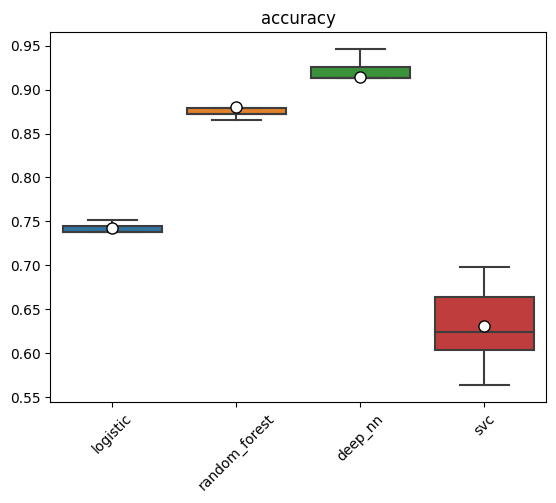

In [80]:
plot_scores(estimator_names, base_scores['rppa'])

## Modality Ensembles

In [81]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        # calculating scores
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method
        
    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])
        
        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking
        
        return model
    
    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)

        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [82]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=5)

In [83]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 33%|███▎      | 1/3 [17:10<34:20, 1030.00s/it]

            accuracy               f1    recall (KICH)    recall (KIRC)  \
rna  0.968 +/- 0.018  0.968 +/- 0.018  0.954 +/- 0.092  0.968 +/- 0.025   

       recall (KIRP)  
rna  0.972 +/- 0.023  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

            accuracy               f1    recall (KICH)    recall (KIRC)  \
cnv  0.882 +/- 0.034  0.881 +/- 0.033  0.732 +/- 0.112  0.925 +/- 0.041   

       recall (KIRP)  
cnv  0.831 +/- 0.053  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

             accuracy               f1    recall (KICH)    recall (KIRC)  \
rppa  0.945 +/- 0.027  0.943 +/- 0.028  0.733 +/- 0.086  0.985 +/- 0.009   

        recall (KIRP)  
rppa  0.920 +/- 0.072  


In [84]:
modality_metrics

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.968 +/- 0.025,0.972 +/- 0.023
cnv,0.882 +/- 0.034,0.881 +/- 0.033,0.732 +/- 0.112,0.925 +/- 0.041,0.831 +/- 0.053
rppa,0.945 +/- 0.027,0.943 +/- 0.028,0.733 +/- 0.086,0.985 +/- 0.009,0.920 +/- 0.072


In [92]:
estimator_names = [
    "logistic",
    "random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['cnv'].append(scores['cnv'])
all_scores['rppa'].append(scores['rppa'])

## Scoring

In [87]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [88]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
random_forest,0.958 +/- 0.021,0.958 +/- 0.021,0.954 +/- 0.092,0.962 +/- 0.020,0.953 +/- 0.033
deep_nn,0.764 +/- 0.344,0.744 +/- 0.370,0.800 +/- 0.400,0.753 +/- 0.377,0.781 +/- 0.391
svc,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.966 +/- 0.025,0.977 +/- 0.015
rna,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.968 +/- 0.025,0.972 +/- 0.023


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.021,0.861 +/- 0.022,0.669 +/- 0.118,0.919 +/- 0.026,0.799 +/- 0.078
random_forest,0.886 +/- 0.024,0.885 +/- 0.023,0.732 +/- 0.159,0.923 +/- 0.032,0.850 +/- 0.052
deep_nn,0.870 +/- 0.034,0.869 +/- 0.034,0.717 +/- 0.087,0.906 +/- 0.039,0.836 +/- 0.064
svc,0.796 +/- 0.048,0.798 +/- 0.046,0.655 +/- 0.128,0.840 +/- 0.069,0.742 +/- 0.031
cnv,0.882 +/- 0.034,0.881 +/- 0.033,0.732 +/- 0.112,0.925 +/- 0.041,0.831 +/- 0.053


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.742 +/- 0.005,0.731 +/- 0.010,0.223 +/- 0.036,0.874 +/- 0.018,0.605 +/- 0.041
random_forest,0.881 +/- 0.017,0.862 +/- 0.022,0.241 +/- 0.106,0.994 +/- 0.009,0.821 +/- 0.032
deep_nn,0.914 +/- 0.024,0.911 +/- 0.026,0.685 +/- 0.092,0.977 +/- 0.008,0.845 +/- 0.047
svc,0.631 +/- 0.047,0.646 +/- 0.044,0.492 +/- 0.114,0.682 +/- 0.058,0.559 +/- 0.060
rppa,0.945 +/- 0.027,0.943 +/- 0.028,0.733 +/- 0.086,0.985 +/- 0.009,0.920 +/- 0.072


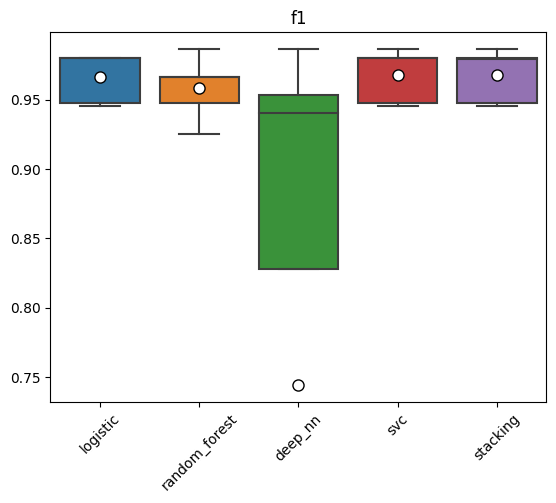

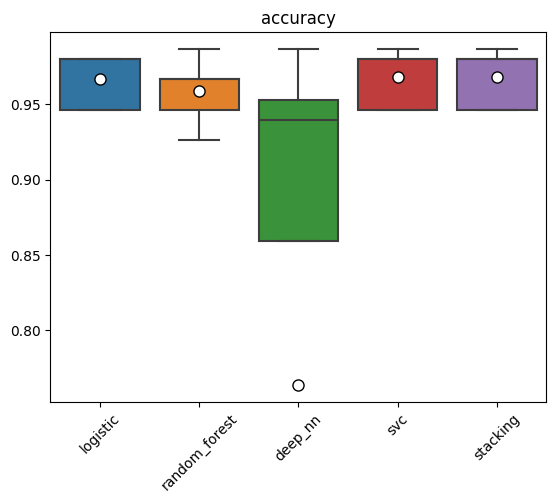

In [89]:
plot_scores(estimator_names, base_scores['rna'])

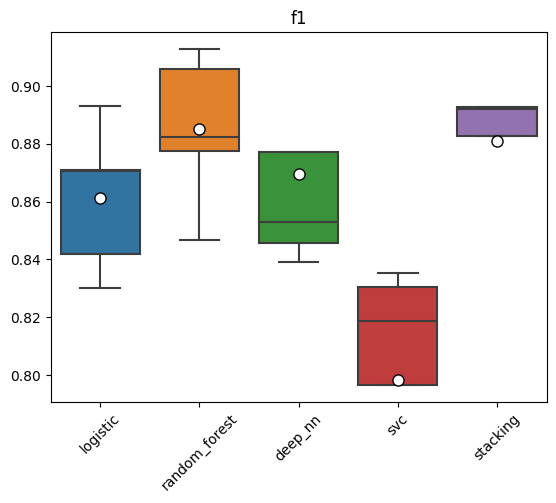

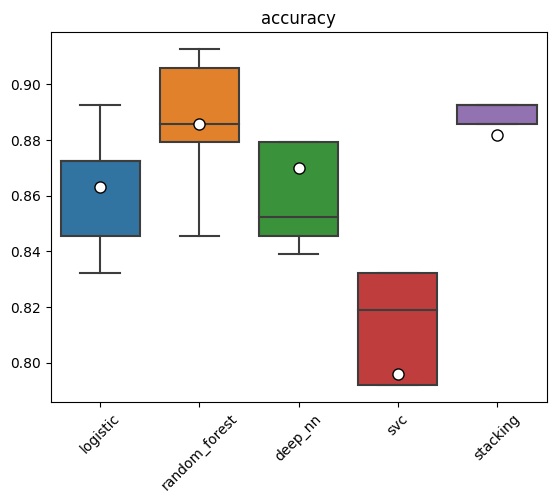

In [90]:
plot_scores(estimator_names, base_scores['cnv'])

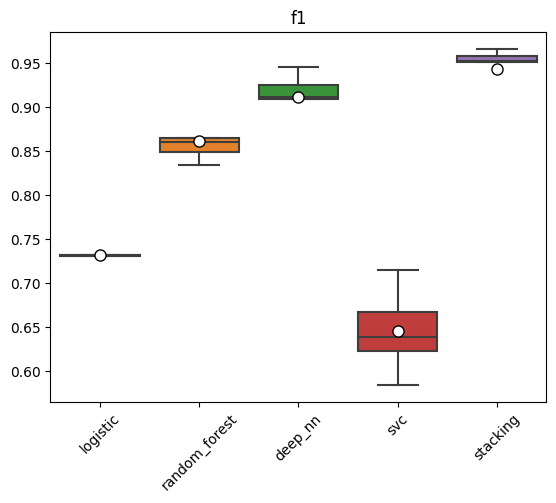

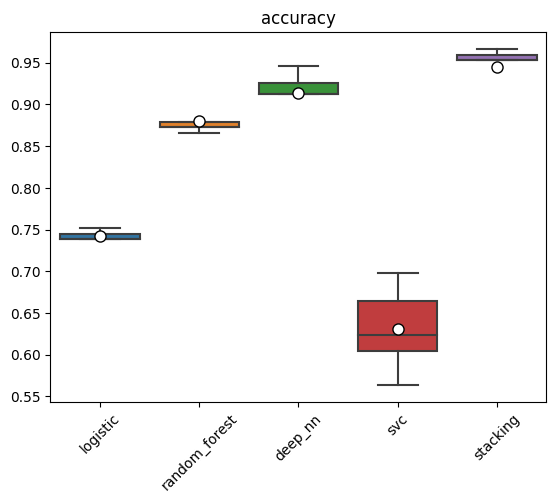

In [91]:
plot_scores(estimator_names, base_scores['rppa'])

# Meta-Ensemble

In [93]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 33%|███▎      | 1/3 [16:19<32:38, 979.12s/it]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing 

In [97]:
pred_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna']), pd.DataFrame(preds['cnv'], columns=['cnv']), pd.DataFrame(preds['rppa'], columns=['rppa'])], axis=1)

In [98]:
pred_df

,rna,cnv,rppa
0,0,0,0
1,0,0,0
2,0,2,0
3,0,1,0
4,0,0,1
...,...,...,...
740,2,2,2
741,2,2,2
742,2,1,2
743,2,2,2


### With Voting:

In [108]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Find the majority class for each sample
majority_class = pred_df.mode(axis=1)[0]

# Calculate the scores
accuracy = accuracy_score(y, majority_class)
f1 = f1_score(y, majority_class, average='weighted')
recall = recall_score(y, majority_class, average=None)

scores_df = pd.DataFrame({'accuracy': [accuracy], 'f1': [f1], 'recall (KICH)': [recall[0]], 'recall (KIRC)': [recall[1]], 'recall (KIRP)': [recall[2]]})

# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, scores_df.rename(index={0: 'majority_class'})])

integration_voting_metrics


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.968 +/- 0.025,0.972 +/- 0.023
cnv,0.882 +/- 0.034,0.881 +/- 0.033,0.732 +/- 0.112,0.925 +/- 0.041,0.831 +/- 0.053
rppa,0.945 +/- 0.027,0.943 +/- 0.028,0.733 +/- 0.086,0.985 +/- 0.009,0.920 +/- 0.072
majority_class,0.969128,0.969151,0.936508,0.976546,0.962441


### With Stacking:

In [101]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), pred_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


In [102]:
integration_metrics

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
Integration Model,0.966 +/- 0.028,0.966 +/- 0.029,0.923 +/- 0.119,0.977 +/- 0.025,0.958 +/- 0.034


In [103]:
names = ['cnv', 'rna', 'rppa', 'integration']
integration = []
integration.append(scores['cnv'])
integration.append(scores['rna'])
integration.append(scores['rppa'])
integration.append(integration_scores)

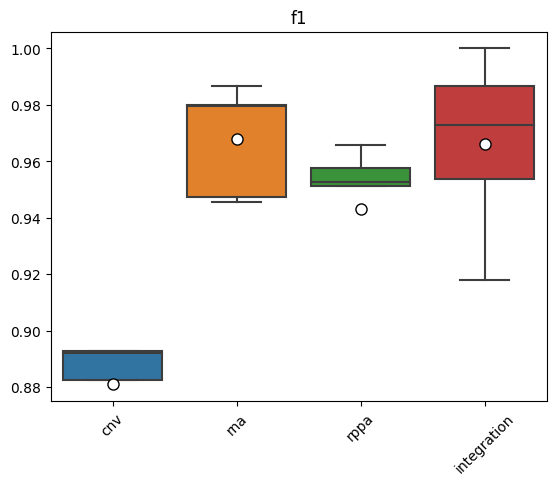

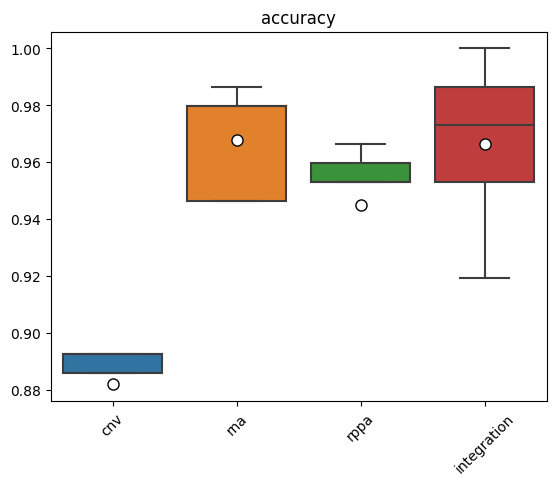

In [104]:
plot_scores(names, integration)